In [1]:
from __future__ import print_function, division
%matplotlib notebook

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from IPython.core.debugger import set_trace
import itertools
import seaborn as sns
from tqdm import tqdm
plt.ion()

# Pose Output Format (BODY_25)
<img src="https://github.com/CMU-Perceptual-Computing-Lab/openpose/raw/master/doc/media/keypoints_pose_25.png" width="300">

# Check cuda.is_available ?

In [2]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("cuda_available : {}, device : {}".format(cuda_available, device))

cuda_available : True, device : cuda:0


In [3]:
part_pairs = [
              #(1,8),
              #(1,2),
              #(1,5),
              #(2,3),
              #(3,4),
              #(5,6),
              #(6,7),
              (8,9),
              (9,10),
              (10,11),
              (8,12),
              (12,13),
              (13,14),
              #(1,0),
              #(0,15),
              #(15,17),
              #(0,16),
              #(16,18),
              #(2,17),
              #(5,18),
              (14,19),
              (19,20),
              (14,21),
              (11,22),
              (22,23),
              (11,24)]

# Define Dataset & DataLoader

In [9]:
class GAITDataset(Dataset):
    def __init__(self, keypoints_pkl_file, targets_pkl_file, phase, split_ratio, maxlen=300):
        keypoints_frame = pd.read_pickle(keypoints_pkl_file)
        targets_frame = pd.read_pickle(targets_pkl_file)[['Velocity']]
        self.maxlen = maxlen
        
        vids = list(set(keypoints_frame.vid))
        
        # drop huge seq
        for i in tqdm(range(len(vids)), desc='DropInputSeq, Phase={} '.format(phase.upper())):
            slice_df = keypoints_frame.loc[keypoints_frame.vid==vids[i]].iloc[:, 2:]
            if slice_df.values.shape[0] > maxlen:
                keypoints_frame.iloc[slice_df.index, 2:] = np.nan * np.empty_like(slice_df.values)
        
        # drop Nans !
        self.keypoints_frame = keypoints_frame.dropna()

        vids = list(set(keypoints_frame.vid))

        # reindex tgt data
        pids = []
        for vid in tqdm(vids, desc='ReindexTarget, Phase={} '.format(phase.upper())):
            split = os.path.splitext(vid)[0].split('_')
            pid = '_'.join([split[0], 'basic', 'test', split[2], 'trial', split[4]])
            pids.append(pid)
            
        self.targets_frame = targets_frame.reindex(pids, fill_value=0.0)
        
        if phase=='train':
            self.vids = vids[:int(len(vids)*split_ratio)]
        elif phase=='test':
            self.vids = vids[-int(len(vids)*split_ratio):]

    def __len__(self):
        return len(self.vids)
    
    def __getitem__(self, idx):
        keypoints_seq = self.keypoints_frame.loc[self.keypoints_frame.vid==self.vids[idx]].iloc[:, 2:].values
        
        # seq_len before padding
        seq_len = len(keypoints_seq)
        
        # zero padding
        keypoints_seq = np.pad(keypoints_seq, ((0,self.maxlen-len(keypoints_seq)),(0,0)),
                                               'constant', constant_values=0).transpose(1,0)
        
        pid, _, test_ix, _, trial_ix, *_ = os.path.splitext(self.vids[idx])[0].split('_')
        
        target_id = '_'.join([pid, 'basic', 'test', test_ix, 'trial', trial_ix])
        targets = self.targets_frame.loc[target_id].values
        
        sample = {'keypoints_seq': torch.tensor(keypoints_seq, dtype=torch.float32).cpu(),
                  'targets': torch.tensor(targets, dtype=torch.float32).cpu(),
                  'seq_len': torch.tensor(seq_len, dtype=torch.int32)}
        
        return sample

# dataset path
keypoints_pkl_file = "./preprocess/data/keypoints_dataframe.pkl"
targets_pkl_file = "./preprocess/data/targets_dataframe.pkl"

In [10]:
dataset = { phase : GAITDataset(keypoints_pkl_file, targets_pkl_file, phase=phase, split_ratio=split_ratio) \
                for phase,split_ratio in zip(['train', 'test'], [0.8, 0.2]) }

dataloader = { phase : DataLoader(dataset[phase],
                        batch_size=32,
                        shuffle=True,
                        num_workers=12) \
                    for phase in ['train', 'test'] }

ReindexTarget, Phase=TEST : 100%|██████████| 3617/3617 [00:00<00:00, 713751.94it/s]


In [22]:
list(dataloader['train'])[0]['targets']

tensor([[ 74.5000],
        [ 94.7000],
        [ 58.7000],
        [ 68.4000],
        [ 76.7000],
        [ 86.8000],
        [ 51.3000],
        [ 67.2000],
        [110.4000],
        [131.0000],
        [ 71.4000],
        [ 63.4000],
        [ 86.5000],
        [ 42.9000],
        [ 42.5000],
        [ 53.9000]])

# Visualize distribution of data

In [ ]:
import seaborn as sns

df_list = []

for phase in ['train', 'test']:
    df_list.append(
        dataset['train'].targets_frame
    )

df = pd.concat(df_list)


single_columns = df.columns[:3]
pair_columns = df.columns[3:]

def Normal(x, mu=0.0, sigma=1.0):
    return (1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2) ))


def visualize_dist_of_factors(df, columns, fig_size=(7,7), subplot_coord=(3,1), paired=False, title=None):

    sns.set(style="white", palette="muted", color_codes=True)

    # Set up the matplotlib figure
    f, axes = plt.subplots(*subplot_coord, figsize=fig_size, sharex=False)
    if title:
        f.suptitle(title, fontsize=16)
    sns.despine(left=True)
    
    for i in range(len(columns)):
        ax = axes[i//2, i%2] if paired else axes[i]
        values = df[columns[i]].values
        mu, sigma = values.mean(), values.std()
        cnt, bins, _ = ax.hist(values, 60, normed=True)
        
        ax.plot(bins, Normal(bins, mu, sigma))
                
    plt.setp(axes, yticks=[])
    plt.tight_layout()


visualize_dist_of_factors(df, single_columns, fig_size=(7,7), subplot_coord=(3,1), paired=False, title='Single Factor Distributions')

visualize_dist_of_factors(df, pair_columns, fig_size=(9,9), subplot_coord=(7,2), paired=True, title='Paired Factor Distributions')

# Define DNN

In [23]:
class Conv1d(nn.Conv1d):
    def __init__(self, in_channels,
                       out_channels,
                       kernel_size,
                       stride=1,
                       padding=0,
                       dilation=1,
                       groups=1,
                       bias=True,
                       padding_type='same'):
        
        super(Conv1d, self).__init__(in_channels,
                                     out_channels,
                                     kernel_size,
                                     stride,
                                     padding,
                                     dilation,
                                     groups,
                                     bias)
        
        self.padding_type = padding_type
    
    def forward(self, x, debug=False):
        _, _, input_length = x.size()
        if debug:
            set_trace()
        if self.padding_type == 'same':
            padding_need = round((input_length * (self.stride[0]-1) + self.kernel_size[0] - self.stride[0]) / 2)
            
        return F.conv1d(x, self.weight, self.bias, self.stride, 
                        padding_need, self.dilation, self.groups)

In [24]:
class ResidualBlock(nn.Module):
    def __init__(self, C_in, C_out, pool, highway=True):
        super(ResidualBlock, self).__init__()
        self.pool = pool
        self.highway = highway
                
        stride = 1
        
        if C_in != C_out:
            C = C_out
        else:
            C = C_in = C_out
            
        if pool:
            # input dimension matchig
            self.conv_1x1_matching = Conv1d(C_in, C, kernel_size=1, stride=1, padding_type='same')
            self.bn_1x1_matching = nn.BatchNorm1d(C)

            # for pooling of residual path
            stride = 2
            self.conv_1x1_pool = Conv1d(C_in, C, kernel_size=1, stride=2, padding_type='same')
            self.bn_1x1_pool= nn.BatchNorm1d(C)
                
        # conv_1x1_a : reduce number of channels by factor of 4 (output_channel = C/4)
        self.conv_1x1_a = Conv1d(C, int(C/4), kernel_size=1, stride=stride, padding_type='same')
        self.bn_1x1_a = nn.BatchNorm1d(int(C/4))
        
        # conv_3x3_b : more wide receptive field (output_channel = C/4)
        self.conv_3x3_b = Conv1d(int(C/4), int(C/4), kernel_size=3, stride=1, padding_type='same')
        self.bn_3x3_b = nn.BatchNorm1d(int(C/4))
        
        # conv_1x1_c : recover org channel C (output_channel = C)
        self.conv_1x1_c = Conv1d(int(C/4), C, kernel_size=1, stride=1, padding_type='same')
        self.bn_1x1_c = nn.BatchNorm1d(C)
        
        if highway:
            # conv_1x1_g : gating for highway network
            self.conv_1x1_g = Conv1d(C, C, kernel_size=1, stride=1, padding_type='same')
        
        # output
        self.bn_1x1_out = nn.BatchNorm1d(C)
        
    
    def forward(self, x):
        '''
            x : size = (batch, C, maxlen)
        '''
        
        res = x
        
        if self.pool:
            # input dimension matching with 1x1 conv
            x = self.conv_1x1_matching(x)
            x = self.bn_1x1_matching(x)
            
            # pooling of residual path
            res = self.conv_1x1_pool(res)
            res = self.bn_1x1_pool(res)
        
        # 1x1_a (C/4)
        x = self.conv_1x1_a(x)
        x = self.bn_1x1_a(x)
        x = F.relu(x)
        
        # 3x3_b (C/4)
        x = self.conv_3x3_b(x)
        x = self.bn_3x3_b(x)
        x = F.relu(x)
        
        # 1x1_c (C)
        x = self.conv_1x1_c(x)
        x = self.bn_1x1_c(x)
        
        if self.highway:
            # gating mechanism from "highway network"
            
            # gating factors controll intensity between x and f(x)
            # gating = 1.0 (short circuit) --> output is identity (same as initial input)
            # gating = 0.0 (open circuit)--> output is f(x) (case of non-residual network)
            gating = torch.sigmoid(self.conv_1x1_g(x))
            
            # apply gating mechanism
            x = gating * res + (1.0 - gating) * F.relu(x)

            
        else:
            # normal residual ops (addition)
            x = F.relu(x) + res
            
#         x = self.bn_1x1_out(x)
#         x = F.relu(x)
        
        return x

In [25]:
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(*self.shape)

class GAP(nn.Module):
    def __init__(self):
        super(GAP, self).__init__()
    def forward(self, x):
        '''
            x : size = (B, C, L)
        '''
        return torch.mean(x, 2)
        
        
class Net(nn.Module):
    def __init__(self, input_size, target_size, num_layers = [3,4,6], num_filters = [64,128,128]):
        super(Net, self).__init__()
        
        self.input_size = input_size
        self.target_size = target_size
        
        def res_blocks(residual_blocks, num_layers, num_filters, block_ix, pool_first_layer=True):
            block_layers = num_layers[block_ix]

            for i in range(block_layers):
                # default values
                pool = False
                block_filters = num_filters[block_ix]
                
                C_in = C_out = block_filters
                
                if pool_first_layer and i==0:
                    pool = True
                if i==0 and block_ix > 0:
                    C_in = num_filters[block_ix-1]
                    
                print(f"layer : {i}, block : {block_ix}, C_in/C_out : {C_in}/{C_out}")
                residual_blocks.append(ResidualBlock(C_in=C_in, C_out=C_out,pool=pool, highway=True))
                
        residual_blocks = []

        for i in range(len(num_layers)):
            pool_first_layer = True
            if i == 0:
                pool_first_layer = False
            res_blocks(residual_blocks, num_layers=num_layers, num_filters=num_filters, block_ix=i,
                       pool_first_layer=pool_first_layer)
                
        self.model = nn.Sequential(nn.Conv1d(input_size, num_filters[0], kernel_size=7, stride=2),
                                   nn.BatchNorm1d(num_filters[0]),
                                   nn.ReLU(),
                                   nn.MaxPool1d(kernel_size=(3,), stride=2,),
                                   nn.Conv1d(num_filters[0], num_filters[0], kernel_size=3, stride=1),
                                   nn.BatchNorm1d(num_filters[0]),
                                   nn.ReLU(),
                                   nn.MaxPool1d(kernel_size=(3,), stride=2,),
                                   *residual_blocks,
                                   GAP(),
                                   nn.Dropout(0.5),
                                   nn.Linear(num_filters[-1], target_size),
                                   )
        
    def forward(self, x):
        '''
            x : size = (batch, input_size, maxlen)
        '''
        return self.model(x)

net = Net(input_size=39,
          target_size=len(dataset['train'].targets_frame.columns),
          num_layers = [3,4,6], num_filters = [64,128,128])
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net)
else:
    print("Single GPU mode")

net.to(device)

layer : 0, block : 0, C_in/C_out : 64/64
layer : 1, block : 0, C_in/C_out : 64/64
layer : 2, block : 0, C_in/C_out : 64/64
layer : 0, block : 1, C_in/C_out : 64/128
layer : 1, block : 1, C_in/C_out : 128/128
layer : 2, block : 1, C_in/C_out : 128/128
layer : 3, block : 1, C_in/C_out : 128/128
layer : 0, block : 2, C_in/C_out : 128/128
layer : 1, block : 2, C_in/C_out : 128/128
layer : 2, block : 2, C_in/C_out : 128/128
layer : 3, block : 2, C_in/C_out : 128/128
layer : 4, block : 2, C_in/C_out : 128/128
layer : 5, block : 2, C_in/C_out : 128/128
Single GPU mode


Net(
  (model): Sequential(
    (0): Conv1d(39, 64, kernel_size=(7,), stride=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=(3,), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=(3,), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ResidualBlock(
      (conv_1x1_a): Conv1d(64, 16, kernel_size=(1,), stride=(1,))
      (bn_1x1_a): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_3x3_b): Conv1d(16, 16, kernel_size=(3,), stride=(1,))
      (bn_3x3_b): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_1x1_c): Conv1d(16, 64, kernel_size=(1,), stride=(1,))
      (bn_1x1_c): BatchNorm1d(64, eps=1e-05, momentum=0.1, a

# Define criterion

In [26]:
# define criterion
# criterion = nn.MSELoss()
# criterion = nn.L1Loss()

def Normal(x, mu=0.0, sigma=1.0):
    if type(x)==torch.Tensor:
        x = x.detach().cpu().numpy()
        
    res = (1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2) )).astype(np.float32)
    return torch.tensor(res).float().to(device)


df_list = []  # list of df to merge

for phase in ['train', 'test']:
    df_list.append(
        dataset['train'].targets_frame
    )

df = pd.concat(df_list)  #  concat

# mean and std from data
mu = df.values.mean(0)
sigma = df.values.std(0)

criterion = lambda x, y : torch.mean( torch.abs(torch.log( 1. / (Normal(x, mu, sigma)+1e-7) )) * torch.pow( (x - y), 2) )

# Training Loop

In [27]:
# cost history saving..
history = {'train': [],
           'test': []}

import torch.optim as optim
from torch.optim import lr_scheduler

# Observe that all parameters are being optimized
# optimizer = optim.Adam(net.parameters(), lr=1e-4)
optimizer = optim.RMSprop(net.parameters(), lr=1e-2)

epoch_loss = {'train': 0.0, 'test': 0.0}
length_vs_mse = []
pred_and_gt = []

end_epoch = 50

print("Start training loop...")

for epoch in range(1,end_epoch+1):        
    for phase in ['train', 'test']:
        if phase=='train':
            net.train()
        elif phase=='test':
            net.eval()
        
        running_loss = 0.0

        for idx, batch_item in enumerate(dataloader[phase]):
            input, target, seq_len = batch_item['keypoints_seq'].to(device), batch_item['targets'].to(device), \
                                      batch_item['seq_len'].to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase=='train'):
                # feed data to network
                output = net(input)

                # compute loss
                loss = criterion(output, target)

                if phase=='train':
                    loss.backward()
                    optimizer.step()
                                    
                if epoch==end_epoch and phase=='test':
                    length_vs_mse.append([seq_len.cpu().numpy(), torch.pow(output[:,0].detach()-target[:,0],2).cpu().numpy()])
                    pred_and_gt.append([output[:,0].detach().cpu().numpy(), target[:,0].cpu().numpy()])
            running_loss += loss.item() * len(input)
            
            
        avg_loss = running_loss / len(dataloader[phase].dataset)
                
        epoch_loss[phase] += avg_loss
        
        if epoch % 10 == 0:
            print('=================={}========================'.format(phase.upper()))
            print('EPOCH : {}, WEIGHTED_SQUARED_ERROR (WSE) : {:.4f}'.format(epoch, epoch_loss[phase] / 10))
            history[phase].append(epoch_loss[phase] / 10)
            
            # init epoch_loss at its own phase
            epoch_loss[phase] = 0.0

Start training loop...
==================TRAIN========================
EPOCH : 10, WEIGHTED_SQUARED_ERROR (WSE) : 1989.1249
==================TEST========================
EPOCH : 10, WEIGHTED_SQUARED_ERROR (WSE) : 2814.3935
==================TRAIN========================
EPOCH : 20, WEIGHTED_SQUARED_ERROR (WSE) : 1432.8934
==================TEST========================
EPOCH : 20, WEIGHTED_SQUARED_ERROR (WSE) : 1316.1766
==================TRAIN========================
EPOCH : 30, WEIGHTED_SQUARED_ERROR (WSE) : 1356.0177
==================TEST========================
EPOCH : 30, WEIGHTED_SQUARED_ERROR (WSE) : 1454.5931
==================TRAIN========================
EPOCH : 40, WEIGHTED_SQUARED_ERROR (WSE) : 1326.6007
==================TEST========================
EPOCH : 40, WEIGHTED_SQUARED_ERROR (WSE) : 1321.0190
==================TRAIN========================
EPOCH : 50, WEIGHTED_SQUARED_ERROR (WSE) : 1336.8579
==================TEST========================
EPOCH : 50, WEIGHTED_SQUA

<IPython.core.display.Javascript object>


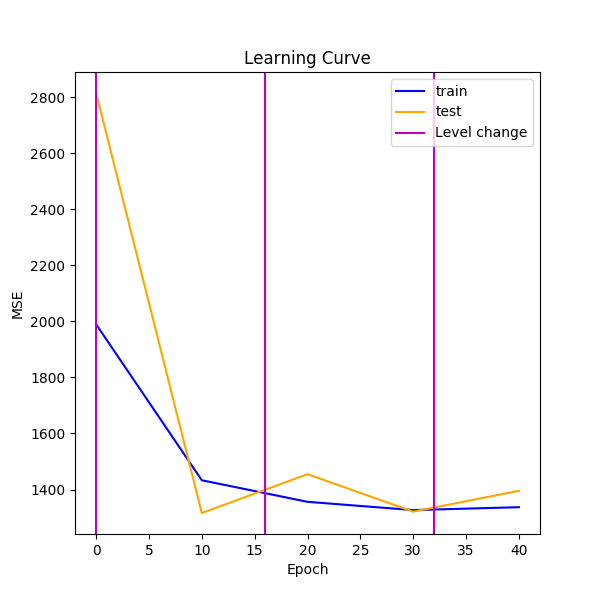

Saving learning curve...


In [28]:
# plot learning curve
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(np.arange(len(history['train'])*10, step=10), history['train'], label='train', color='b')
ax.plot(np.arange(len(history['test'])*10, step=10), history['test'], label='test', color='orange')

label = 'Level change'
for x,level in zip(range(0,end_epoch,int(end_epoch/3)), ['easy','hard','target']):
    ax.axvline(x, color='m', label=label)
    label=None

ax.set_title('Learning Curve')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
plt.legend()

print("Saving learning curve...")
fig.savefig('learning.png', dpi=fig.dpi)

<IPython.core.display.Javascript object>


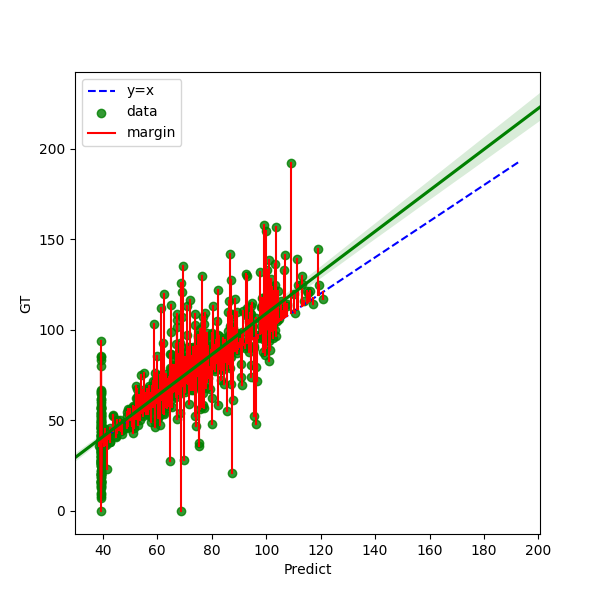

In [17]:
tranposed_data = list(zip(*pred_and_gt))
preds = np.concatenate(tranposed_data[0])
gts = np.concatenate(tranposed_data[1])

df = pd.DataFrame(np.c_[preds,gts], columns=['Predict', 'GT'])

fig = plt.figure(figsize=(6,6))
plt.plot([min(preds)-0.5, max(gts)+0.5], [min(preds)-0.5, max(gts)+0.5], 'b--', label='y=x')

label = 'margin'
for xs,ys in zip(preds, gts):
    xe = ye = xs
    plt.plot([xs, xe], [ys, ye], 'r', label=label)
    label = None
    
    
sns.regplot("Predict", "GT", data=df,color="g",label='data')
#plt.xlim((min(preds)-0.5, max(preds)+0.5))


handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

In [18]:
list(zip(*[preds.tolist(), gts.tolist()]))

[(51.82351303100586, 53.0),
 (69.81865692138672, 28.0),
 (71.61754608154297, 75.9000015258789),
 (102.54287719726562, 95.19999694824219),
 (96.13760375976562, 96.0999984741211),
 (90.81864929199219, 73.5999984741211),
 (39.452388763427734, 33.0),
 (52.66538619995117, 54.5),
 (76.27308654785156, 83.4000015258789),
 (45.97023010253906, 44.400001525878906),
 (65.61436462402344, 80.4000015258789),
 (57.33531951904297, 56.400001525878906),
 (62.53361511230469, 57.900001525878906),
 (56.02220153808594, 53.5),
 (64.92227172851562, 70.4000015258789),
 (73.66653442382812, 86.19999694824219),
 (77.39277648925781, 81.30000305175781),
 (66.36143493652344, 71.80000305175781),
 (42.758628845214844, 45.599998474121094),
 (73.91746520996094, 102.69999694824219),
 (98.22335815429688, 112.69999694824219),
 (87.73738098144531, 61.29999923706055),
 (39.452388763427734, 7.0),
 (41.31851577758789, 36.400001525878906),
 (39.452388763427734, 49.400001525878906),
 (64.71086120605469, 68.0),
 (59.95394515991211

In [ ]:
gts[:30]

In [ ]:
transposed_test = list(zip(*length_vs_mse))

x = np.concatenate(transposed_test[0])[:, None]
y = np.concatenate(transposed_test[1])[:, None]
df = pd.DataFrame(np.c_[x,y], columns=['SEQ_LEN', 'MSE'])
plt.figure(figsize=(8,4))
g = sns.jointplot("SEQ_LEN", "MSE", data=df, kind="reg",color="m", height=7)